In [2]:
! pip install opencv-python
# not necessary

     --------------------------------------- 38.1/38.1 MB 12.3 MB/s eta 0:00:00


In [99]:
# All the imports
import sys
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.python.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Concatenate, Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.optimizers import legacy
from keras.activations import relu
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import itertools
import os
import datetime as datetime
import time
from keras.metrics import categorical_accuracy

os.environ['Tf_CPP_MIN_LOG_LEVEL']='2'

In [8]:
test_image_list = os.listdir('dataset/train')
print("We have {0} kind of emotion images in the train directory".format(len(test_image_list)))

test_image_list = os.listdir('dataset/test')
print("We have {0} kind of emotion images in the test directory".format(len(test_image_list)))

We have 7 kind of emotion images in the train directory
We have 7 kind of emotion images in the test directory


### Data Description

{'angry': 3995, 'disgusted': 436, 'fearful': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprised': 3171}


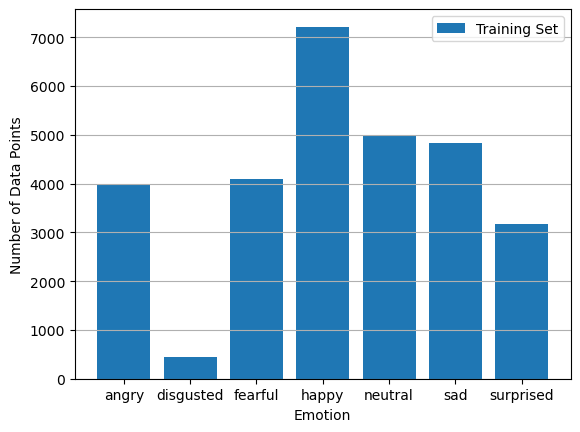

In [9]:
# Randomly Visualize the Images
train_dir = "dataset/train"
train_class_num = {}
test_class_num = {}
for each in os.listdir(train_dir):
    train_path = os.path.join(train_dir,each)
    train_length = len(os.listdir(train_path))
    train_class_num[each] = train_length
print(train_class_num)


plt.bar(*zip(*train_class_num.items()),label="Training Set")
plt.ylabel("Number of Data Points")
plt.xlabel("Emotion")
plt.legend()
plt.grid(axis='y')
plt.savefig("Train Data Distribution.png", dpi=300)

{'angry': 958, 'disgusted': 111, 'fearful': 1024, 'happy': 1774, 'neutral': 1233, 'sad': 1247, 'surprised': 831}


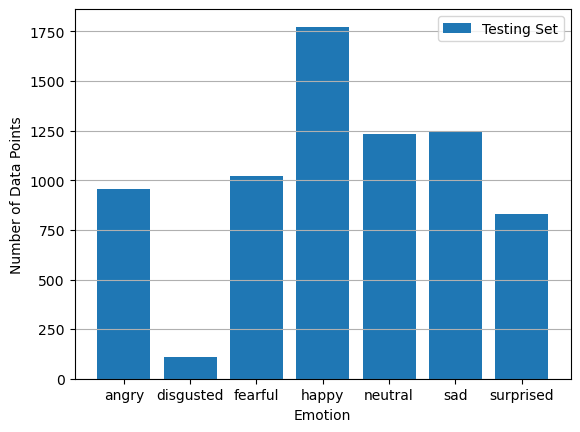

In [10]:
test_dir = 'dataset/test'
test_class_num = {}
for each in os.listdir(test_dir):
    test_path = os.path.join(test_dir,each)
    test_length = len(os.listdir(test_path))
    test_class_num[each] = test_length
print(test_class_num)


plt.bar(*zip(*test_class_num.items()), label="Testing Set")
plt.ylabel("Number of Data Points")
plt.xlabel("Emotion")
plt.legend()
plt.grid(axis='y')
plt.savefig("Test Data Distribution.png", dpi=300)

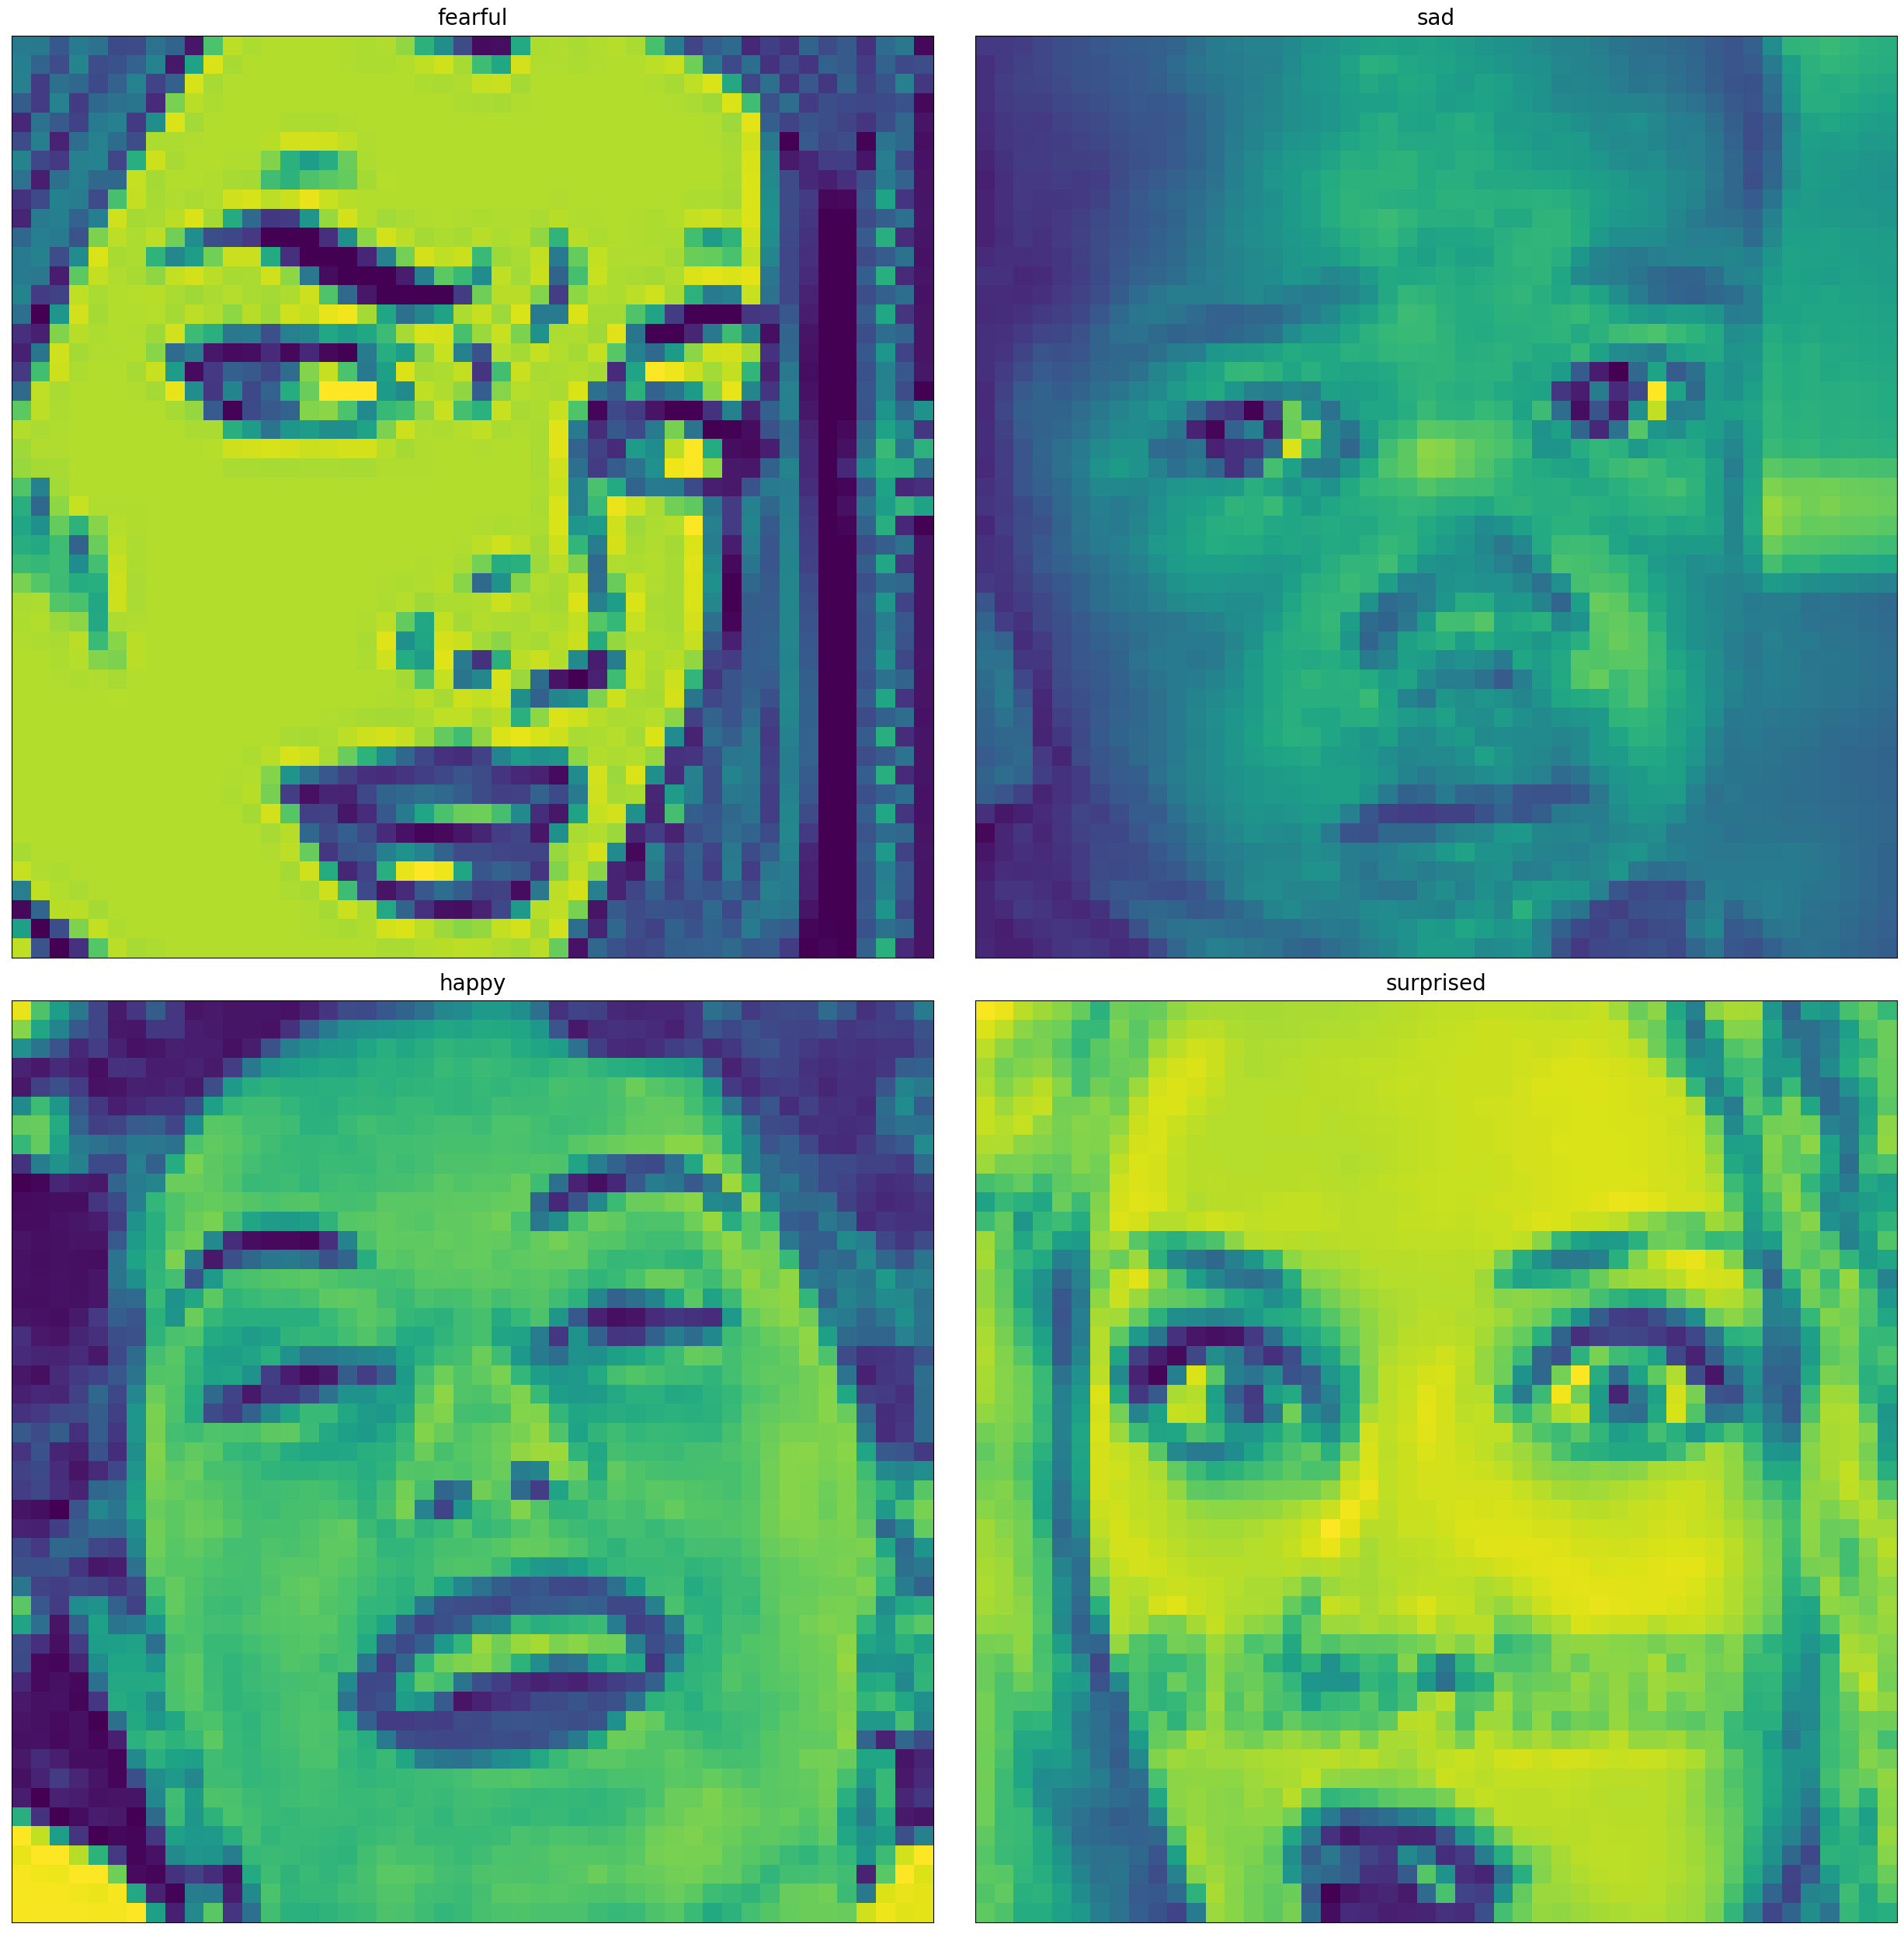

In [11]:
# Visualize the data, showing one image per class from 7 classes
rows = 2
cols = 2
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
#fig.suptitle("Showing random image from the Dataset", y=1.0, fontsize=28)
data_dir = "dataset/train"
emotions_sorted = sorted(os.listdir(data_dir))
emotion_id = 0
for i in range(rows):
      for j in range(cols):
        try:
            emotion_id = np.random.randint(1,7)
            selected_emotion = emotions_sorted[emotion_id]
            selected_emotion_images = os.listdir(os.path.join(data_dir,selected_emotion)) # returns the list of all files present in each emotion category
            selected_emotion_random = np.random.choice(selected_emotion_images) # picks one emotion item from the list as choice, takes a list and returns one random item
            img = plt.imread(os.path.join(data_dir,selected_emotion, selected_emotion_random))
            ax[i][j].imshow(img)
            ax[i][j].set_title(selected_emotion, fontsize = 20, pad = 10)
        except:
            break

plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
plt.savefig("images_overview.png", dpi=300)

### Data Preprocessing

In [60]:
number_of_emotions = 7
trainSize = 28709 #= to the dataset
validationSize = 7178 # = to the dataset
batchSize = 64 # How many samples to train, I like values ^2. High values require more mem.
epochNumber = 30 # How many epochs we use to train.
learnR =0.005 # How fast (how big of a change in weights) happens as we train the network
decayR =1e-6 # Reduce learning rate as we train


#Model parameters: make sure data is in correct location
trainData = 'dataset/train'
validationData ='dataset/test'


#Rescale. RGB values range between 0-255. Rescale simply changes the value to be between 0-1, reducing computation. Need to change this is we use HSV etc
trainRescale = ImageDataGenerator(rescale=1./255)
validationRescale =ImageDataGenerator(rescale=1./255)

trainGenerator= trainRescale.flow_from_directory(trainData,
                                                 target_size=(48,48), batch_size=batchSize,color_mode="grayscale",
                                                 class_mode="categorical") # set training param
validationGenerator= validationRescale.flow_from_directory(validationData,
                                                           target_size=(48,48), batch_size=batchSize, color_mode="grayscale",
                                                            class_mode="categorical") # set validation param


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [61]:
class timecallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.times = []
        # use this value as reference to calculate cummulative time taken
        self.timetaken = time.process_time()
    def on_epoch_end(self,epoch,logs = {}):
        self.times.append((epoch,time.process_time() - self.timetaken))
    def on_train_end(self,logs = {}):
        plt.xlabel('Epoch')
        plt.ylabel('Total time taken until an epoch in seconds')
        plt.plot(*zip(*self.times))
        plt.show()

### GoogleNET Modelling

In [62]:
# Sequential Model Definition
def create_googlenet_model():
    model = Sequential()
    inputs = keras.Input(shape=(48,48,1), name='Input')
    x = layers.Conv2D(32, 3, padding='same', kernel_regularizer = regularizers.l2(0.01),
                    name='Conv_1')(inputs)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding='same', kernel_regularizer = regularizers.l2(0.01),
                    name='Conv_2')(x)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.MaxPooling2D()(x)


    x = layers.Conv2D(128, 3, padding='same', kernel_regularizer = regularizers.l2(0.01), name='Conv_3')(x)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(32, 3, padding='same', kernel_regularizer = regularizers.l2(0.01), name='Conv_4')(x)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)

    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer = regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(number_of_emotions, activation='softmax')(x)
    model = keras.Model(inputs=inputs, outputs=output)

    return model

In [63]:
googlenet_model = create_googlenet_model()
# opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
googlenet_model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=[categorical_accuracy])

Epoch 1/30
448/448 [==============================] - 129s 286ms/step - loss: 1.3528 - categorical_accuracy: 0.3053 - val_loss: 0.6394 - val_categorical_accuracy: 0.2973
Epoch 2/30
448/448 [==============================] - 120s 269ms/step - loss: 0.4678 - categorical_accuracy: 0.4271 - val_loss: 0.4028 - val_categorical_accuracy: 0.4277
Epoch 3/30
448/448 [==============================] - 126s 281ms/step - loss: 0.3683 - categorical_accuracy: 0.4726 - val_loss: 0.3532 - val_categorical_accuracy: 0.4849
Epoch 4/30
448/448 [==============================] - 131s 292ms/step - loss: 0.3459 - categorical_accuracy: 0.4952 - val_loss: 0.3543 - val_categorical_accuracy: 0.4495
Epoch 5/30
448/448 [==============================] - 133s 297ms/step - loss: 0.3369 - categorical_accuracy: 0.5121 - val_loss: 0.3602 - val_categorical_accuracy: 0.4671
Epoch 6/30
448/448 [==============================] - 142s 316ms/step - loss: 0.3312 - categorical_accuracy: 0.5254 - val_loss: 0.3914 - val_categoric

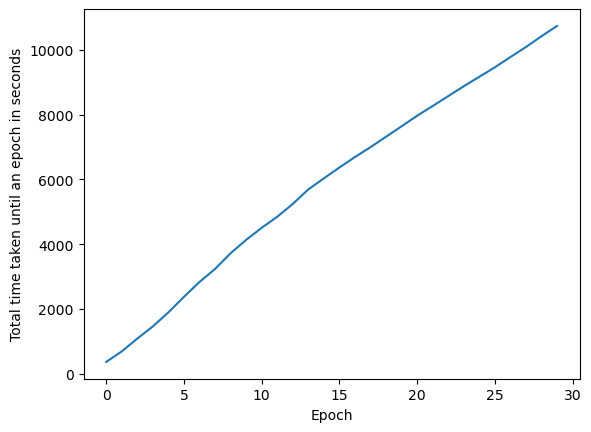

In [64]:
K.clear_session()

csv_logger = CSVLogger('history_googlenet.log')

googlenet_history = googlenet_model.fit(trainGenerator,
                    steps_per_epoch = trainSize // batchSize,
                    validation_data=validationGenerator,
                    validation_steps=validationSize // batchSize,
                    epochs=epochNumber,
                    verbose=1,
                    callbacks=[csv_logger, timecallback()])


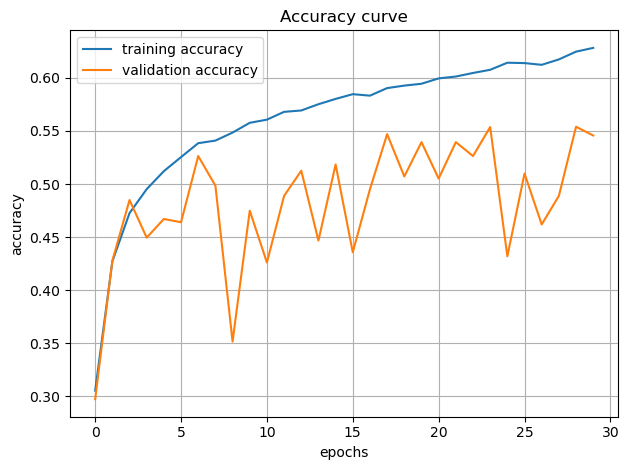

In [105]:
history= googlenet_history
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
epochs = range(len(acc))

plt.plot(acc, label='training accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.title('Accuracy curve')
plt.xlabel('epochs')
plt.grid()
plt.ylabel('accuracy')
plt.legend()

plt.tight_layout()
plt.savefig("google net result.png", dpi=300)

#####  Evaluation Functions

In [67]:
# Downloading images from internet using the URLs
!wget -O angry.jpg https://images.unsplash.com/photo-1584518969469-c2d99c7760a0?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=880&q=80
!wget -O surprised.jpg https://img.freepik.com/free-photo/close-up-portrait-funny-bearded-male-looks-with-surprisement-touches-cheeks-opens-mouth-can-t-beleive-something-isolated-white-wall-people-emotions-concept_273609-15100.jpg?w=1060&t=st=1686882560~exp=1686883160~hmac=d0f58b7b48d8795824a4c8361e895c278f8ce9185772ee09c7d1f352dd78ec0e
!wget -O sad.jpg https://img.freepik.com/free-photo/angry-teen-asian-girl-standing-offended-pose-frowning-sulking-feeling-defensive-standing-disa_1258-83139.jpg?w=1060&t=st=1686882632~exp=1686883232~hmac=378ab867c7c29ab13466f02b122420d3ca47af91882cbdccd3e82598cac45ecc
!wget -O happy.jpg https://img.freepik.com/free-photo/enjoying-life-positive-beautiful-asian-millennial-girl-has-fun-dances-carefree-smiles-broadly-dressed-stylish-jacket-isolated-pink-wall-moves-favorite-song-keeps-hands-up_273609-49520.jpg?w=1060&t=st=1686882751~exp=1686883351~hmac=b6e93d90f4d53ea1bc076945bbb19096876bf6ea2db0be800eaecb02e3ea24ff

'wget' is not recognized as an internal or external command,
operable program or batch file.
'ixid' is not recognized as an internal or external command,
operable program or batch file.
'auto' is not recognized as an internal or external command,
operable program or batch file.
'fit' is not recognized as an internal or external command,
operable program or batch file.
'w' is not recognized as an internal or external command,
operable program or batch file.
'q' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
't' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
't' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or ba

In [68]:
emotions_list = ['angry', 'disgusted','fearful','happy', 'neutral','sad', 'surprised', ]

In [82]:
# Make a list of downloaded images and test the trained model
images = []
images.append('angry.jpg')
images.append('surprised.jpg')
images.append('sad.jpg')
images.append('happy.jpg')

In [120]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    

In [121]:
def internet_img_test(model, images):
    for img in images:
        img_path = img
        print(img_path)
        img = image.load_img(img_path, target_size=(48, 48, 1), grayscale=True)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.

        prediction = model.predict(img_array)
        predicted_class = np.argmax(prediction)
        predicted_class_name = emotions_list[predicted_class]

In [122]:
def plot_confusion_mtx(model, name):
    #Confution Matrix
    Y_pred = model.predict_generator(validationGenerator)
    y_pred = np.argmax(Y_pred, axis=1)
    print('Confusion Matrix')
    cm = confusion_matrix(validationGenerator.classes, y_pred)
    plot_confusion_matrix(cm, emotions_list, title='Confusion Matrix')
    #Print Classification Report
    print('Classification Report')
    print(classification_report(validationGenerator.classes, y_pred, target_names=emotions_list))
    plt.savefig(name +'.png', dpi=300)

### GoogleNET Evaluation

angry.jpg


C:\Users\Abayomi\anaconda3\lib\site-packages\keras\utils\image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


1/1 [==============================] - 0s 39ms/step
surprised.jpg
1/1 [==============================] - 0s 48ms/step
sad.jpg
1/1 [==============================] - 0s 50ms/step
happy.jpg
1/1 [==============================] - 0s 48ms/step


C:\Users\Abayomi\AppData\Local\Temp\ipykernel_16104\2509391377.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(validationGenerator)


Confusion Matrix
Normalized confusion matrix
Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.24      0.17       958
   disgusted       0.00      0.00      0.00       111
     fearful       0.14      0.10      0.12      1024
       happy       0.24      0.19      0.21      1774
     neutral       0.16      0.13      0.14      1233
         sad       0.18      0.23      0.20      1247
   surprised       0.11      0.09      0.10       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.13      7178
weighted avg       0.17      0.17      0.16      7178



C:\Users\Abayomi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abayomi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abayomi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


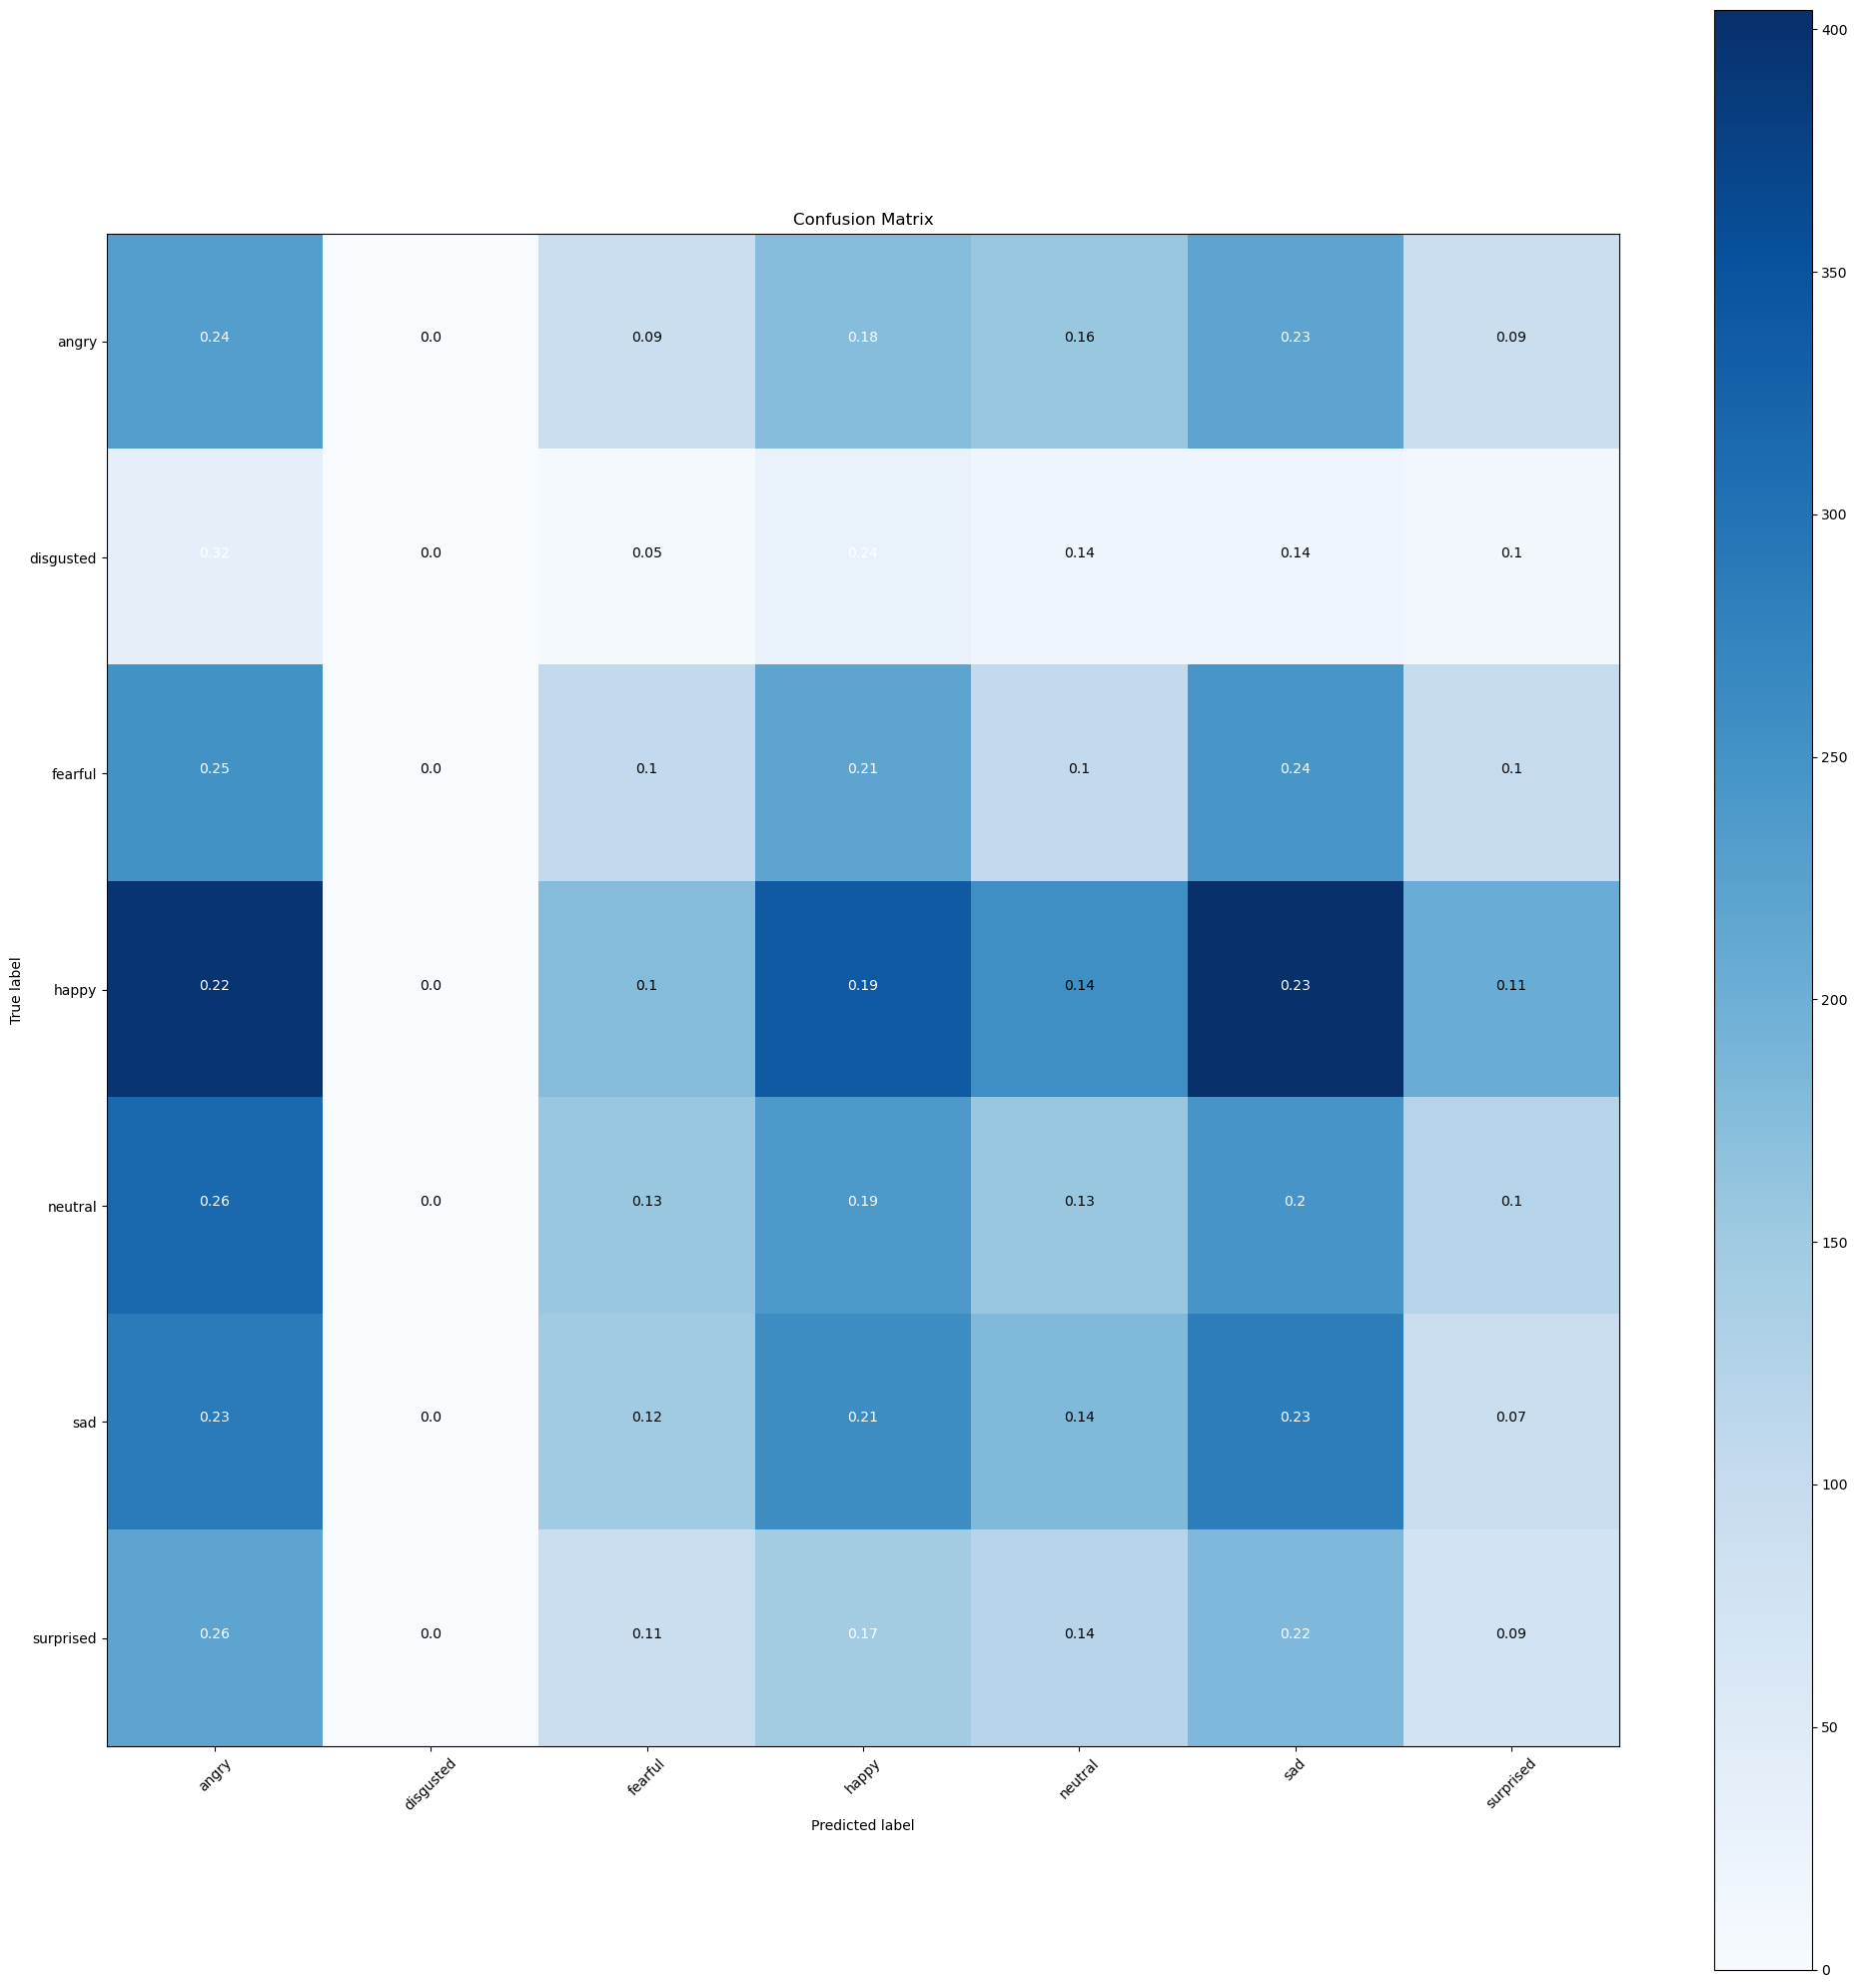

In [123]:
internet_img_test(googlenet_model, images)
plot_confusion_mtx(googlenet_model, 'ggnet_cfx')

### VGG16 Modelling

In [100]:
img_size_target = 48
img_input = Input(shape=(img_size_target, img_size_target, 1))
img_conc = Concatenate()([img_input, img_input, img_input])  
#model = VGG16() 

vgg16 = VGG16(
        input_tensor=img_conc,
        include_top=False,
        weights="imagenet")
base = vgg16.output


x = GlobalAveragePooling2D(name='GlobalPooling')(base)
x = Dense(128,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3,name='Dropout2')(x)
x = Dense(256,activation='relu',name='Dense2')(x)
x = BatchNormalization()(x)
x = Dropout(0.3,name='Dropout3')(x)

predictions = Dense(number_of_emotions,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

In [101]:

#opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
# Binary classification loss
#loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=False)
vgg_model = Model(inputs=vgg16.input, outputs=predictions)
vgg_model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=[categorical_accuracy])

Epoch 1/30
448/448 [==============================] - 2022s 5s/step - loss: 0.5947 - categorical_accuracy: 0.1922 - val_loss: 0.4489 - val_categorical_accuracy: 0.2490
Epoch 2/30
448/448 [==============================] - 1803s 4s/step - loss: 0.4372 - categorical_accuracy: 0.2581 - val_loss: 0.8114 - val_categorical_accuracy: 0.2471
Epoch 3/30
448/448 [==============================] - 1433s 3s/step - loss: 0.3723 - categorical_accuracy: 0.3706 - val_loss: 0.6152 - val_categorical_accuracy: 0.2037
Epoch 4/30
448/448 [==============================] - 1414s 3s/step - loss: 0.3328 - categorical_accuracy: 0.4348 - val_loss: 0.3257 - val_categorical_accuracy: 0.4185
Epoch 5/30
448/448 [==============================] - 1429s 3s/step - loss: 0.3113 - categorical_accuracy: 0.4754 - val_loss: 0.3503 - val_categorical_accuracy: 0.4057
Epoch 6/30
448/448 [==============================] - 2253s 5s/step - loss: 0.2951 - categorical_accuracy: 0.5090 - val_loss: 0.3392 - val_categorical_accuracy:

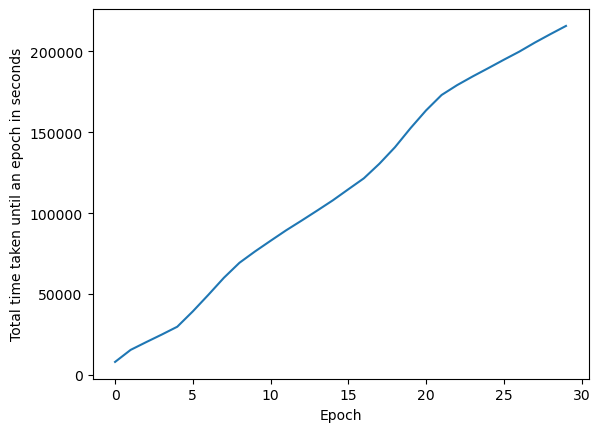

In [102]:
K.clear_session()

csv_logger = CSVLogger('history_vgg16.log')

vgg_history = vgg_model.fit(trainGenerator,
                    steps_per_epoch = trainSize // batchSize,
                    validation_data=validationGenerator,
                    validation_steps=validationSize // batchSize,
                    epochs=epochNumber,
                    verbose=1,
                    callbacks=[csv_logger, timecallback()])


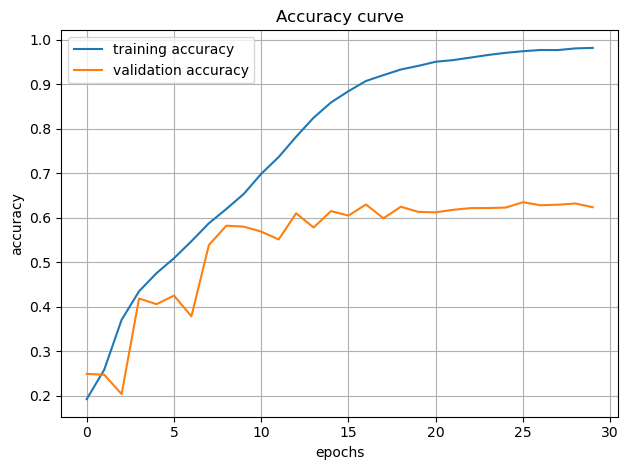

In [106]:
history= vgg_history
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
epochs = range(len(acc))

plt.plot(acc, label='training accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.title('Accuracy curve')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()
plt.legend()

plt.tight_layout()
plt.savefig("vgg16 net result.png", dpi=300)

### VGG16 Evaluation

angry.jpg


C:\Users\Abayomi\anaconda3\lib\site-packages\keras\utils\image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


1/1 [==============================] - 0s 73ms/step
surprised.jpg
1/1 [==============================] - 0s 69ms/step
sad.jpg
1/1 [==============================] - 0s 75ms/step
happy.jpg
1/1 [==============================] - 0s 68ms/step


C:\Users\Abayomi\AppData\Local\Temp\ipykernel_16104\2509391377.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(validationGenerator)


Confusion Matrix
Normalized confusion matrix
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.15      0.14       958
   disgusted       0.00      0.00      0.00       111
     fearful       0.13      0.07      0.09      1024
       happy       0.23      0.26      0.25      1774
     neutral       0.17      0.18      0.17      1233
         sad       0.18      0.15      0.16      1247
   surprised       0.11      0.12      0.11       831

    accuracy                           0.17      7178
   macro avg       0.14      0.13      0.13      7178
weighted avg       0.17      0.17      0.16      7178



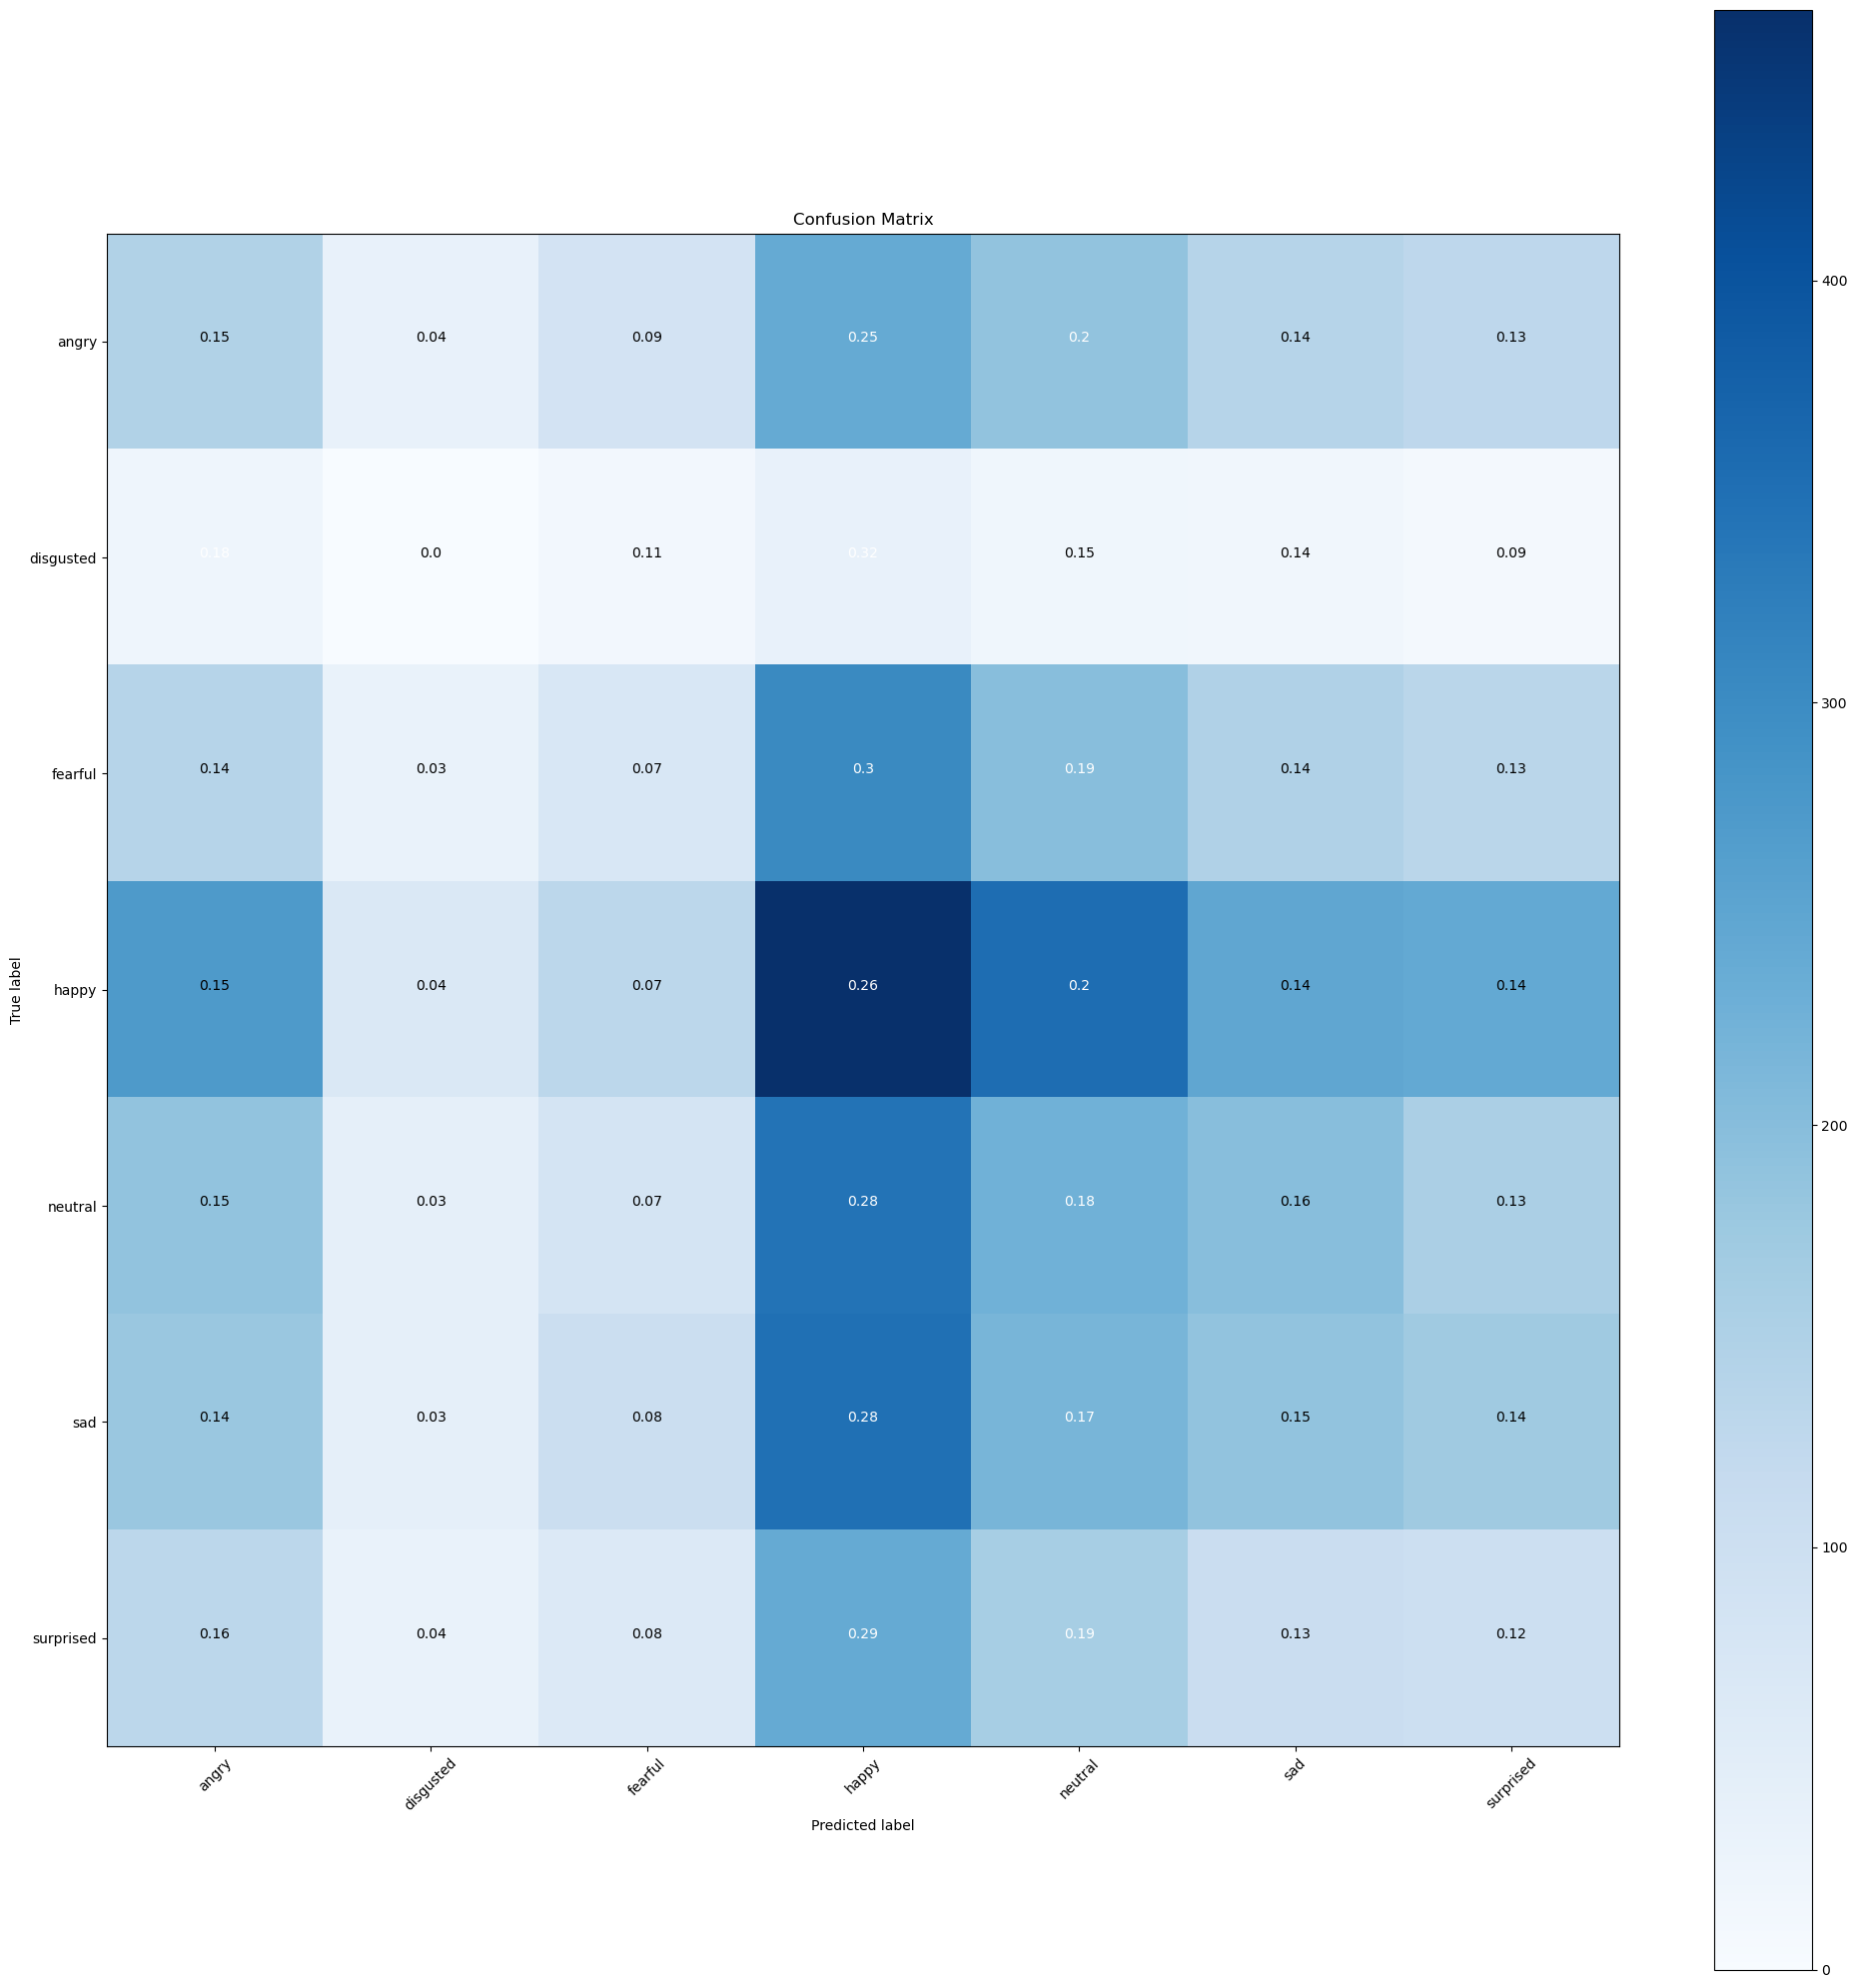

In [124]:
internet_img_test(vgg_model, images)
plot_confusion_mtx(vgg_model, 'vgg_cfx')